# Copolymerization

## Overview

The `polykin.copolymerization` module offers a number of classes to analyze copolymerization behavior and fit experimental copolymerization data.

| Class                      |     Monomer reactivity ratios     | Radical reactivity ratios |
|----------------------------|:---------------------------------:|:-------------------------:|
| `TerminalModel`            |             $r_1, r_2$            |             —             |
| `ImplicitPenultimateModel` |             $r_1, r_2$            |         $s_1, s_2$        |
| `PenultimateModel`         | $r_{11}, r_{12}, r_{21}, r_{22}$  |         $s_1, s_2$        |

The terminal model is the simplest and the usual starting point for copolymerization modeling. The implicit penultimate model is recommended when the terminal model effectively describes copolymer composition but falls short in representing $\bar{k}_p$. Finally, the (full) penultimate model can be employed when penultimate effects become evident in copolymer composition.

## Copolymerization analysis

All copolymerization models listed above share the same basic functionality. In this first part of the tutorial, we will employ the terminal model to analyze the copolymerization behavior of the styrene(1) / methyl methacrylate(2) system.

In [1]:
# %pip install polykin
from polykin.copolymerization import TerminalModel

To instantiate a copolymerization model, we call the constructor of the respective class with the desired reactivity ratios (mandatory arguments) and, optionally, additional arguments.

In [2]:
# Reactivity ratios from Fukuda et al. (1985)
tm = TerminalModel(
    r1=0.523, r2=0.460, M1='ST', M2='MMA', name='TM-Fukuda'
)

The most important properties of the object can be displayed by evaluating it directly.

In [3]:
tm

name:   TM-Fukuda
M1:     ST
M2:     MMA
k1:     None
k2:     None
r1:     0.523
r2:     0.46

### Azeotropic composition

Since both reactivity ratios are less than 1, this system exhibits an azeotrope, and its composition can be determined using the `azeo` property.

In [4]:
f1_azeo = tm.azeotrope
f1_azeo

0.5309734513274337

### Instantaneous copolymer composition

The instantaneous copolymer composition corresponding to a given comonomer composition can be calculated with the method `F1()`. Let's confirm the azeotrope is really an azeotrope.

In [5]:
tm.F1(f1_azeo)

0.5309734513274337

The relationship between comonomer composition and and instantaneous copolymer composition can be plotted with the method `plot(kind='Mayo')`. 

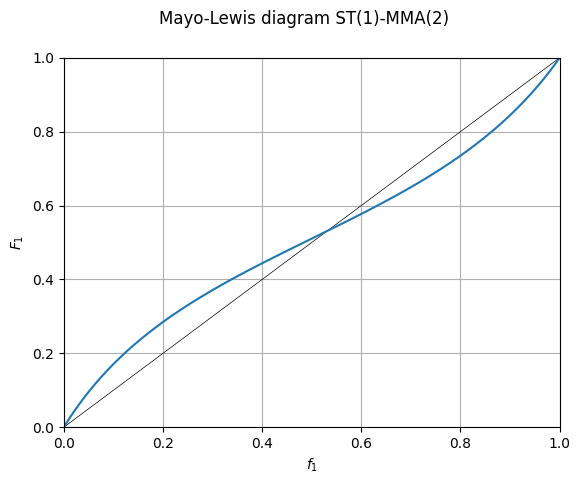

In [6]:
tm.plot('Mayo')
# tm.plot('Mayo', M=2) # this would generate a plot F2(f2)

### Composition drift

When copolymerizing two monomers with different reactivities in a closed system, there is a preferential consumption of the more reactive monomer, leading to a change in composition known as _drift_. This drift can be calculated using the `drift()` method, which requires two mandatory arguments: the initial composition `f10` and the total monomer conversion `x`. The solution is obtained through direct numerical integration.

In [7]:
tm.drift(f10=0.2, x=[0.50, 0.98]) # f10 and x can be scalars or array-like

array([0.14153041, 0.00742268])

To visualize the composition drift, we can use the method `plot(kind='drift')` with the initial monomer composition as argument `f0`.

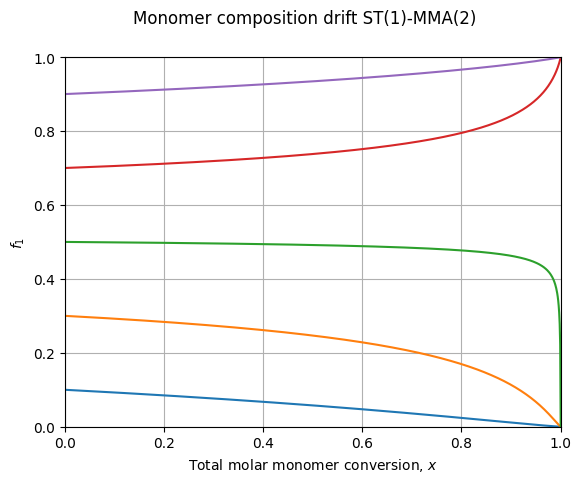

In [8]:
tm.plot('drift', f0=[0.1, 0.3, 0.5, 0.7, 0.9], M=1)

### Sequence length

The instantaneous sequence length distribution and the number-average sequence length distribution can be computed with the `sequence()` method.

In [9]:
# number average sequence length
tm.sequence(f1=0.8, k=None)

{'1': 3.091999999999998, '2': 1.1149999999999998}

In [10]:
# fraction of sequences of length k
tm.sequence(f1=0.8, k=[1, 2, 3])

{'1': array([0.32341527, 0.21881783, 0.1480488 ]),
 '2': array([0.89686099, 0.09250136, 0.0095405 ])}

### Triad fractions

The instantaneous triad fractions can be computed with the `triads()` method, which returns the fractions of triads centered around units 1 and 2.

In [11]:
tm.triads(f1=[0.25, 0.5, 0.75])

{'111': array([0.00728134, 0.06020745, 0.25743437]),
 '112': array([0.08353354, 0.23023881, 0.32815088]),
 '212': array([0.23957994, 0.22011358, 0.10457326]),
 '222': array([0.22512466, 0.04858582, 0.0054765 ]),
 '221': array([0.32626762, 0.2112427 , 0.0714326 ]),
 '121': array([0.1182129 , 0.22961163, 0.2329324 ])}

### Average propagation rate coefficient

The variation of $\bar{k}_p$ with monomer composition can also be calculated if information about the homopropagation coefficients is provided. To do so, we construct `Arrhenius` objects (see tutorial [Kinetic Coefficients](./kinetic_coefficients)) for both propagation rate constants.

In [12]:
from polykin.kinetics import Arrhenius

In [13]:
# From Beuermann et al. (2022)
k1 = Arrhenius(
    10**7.51, 31.8e3/8.314, Tmin=261.0, Tmax=393.0,
    symbol='k_p(ST)', unit='L/mol/s', name='kp of ST'
)

k2 = Arrhenius(
    10**6.50, 22.8e3/8.314, Tmin=255.0, Tmax=365.0,
    symbol='k_p(MMA)', unit='L/mol/s', name='kp of MMA'
)

And we redefine the copolymerization model with the additional information.

In [14]:
tm = TerminalModel(
    r1=0.523, r2=0.460, k1=k1, k2=k2,
    M1='ST', M2='MMA', name='TM-Fukuda'
)

The average $k_p$ can be evaluated with the `kp()` method. Let's estimate the value at 25°C and 50 mol% styrene.

In [15]:
tm.kp(f1=0.5, T=25, Tunit='C')

np.float64(199.8971318596096)

To visualize the effect of composition, we can use the method `plot(kind='kp')`.

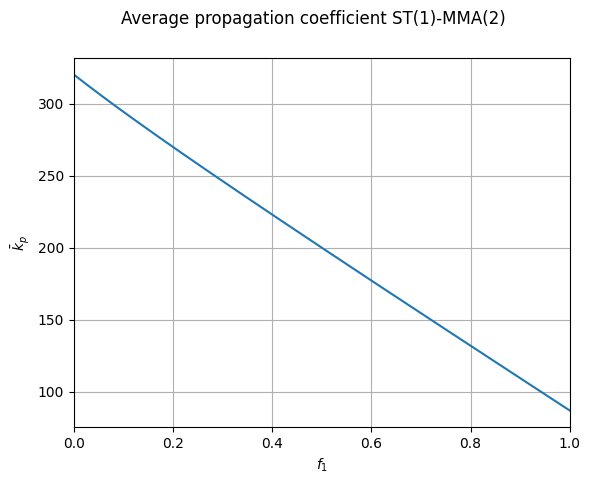

In [16]:
tm.plot(kind='kp', T=25., Tunit='C')

Unfortunately, this variation of $\bar{k}_p$ with $f_1$ does not conform to experimental observations. To understand why, please continue reading.

## Comparing models

The copolymerization of styrene and MMA is a classic example of a system with implicit penultimate effects. This is an excellent opportunity to showcase the class `ImplicitPenultimateModel` and illustrate how to compare models.

In [17]:
from polykin.copolymerization import ImplicitPenultimateModel

In [18]:
# Reactivity ratios from Davis et al. (1989)
pm = ImplicitPenultimateModel(
    r1=0.472, r2=0.454, s1=0.466, s2=0.176, k1=k1, k2=k2,
    M1='ST', M2='MMA', name='IMPU-Davis'
)

While the numerical values of the monomer reactivity ratios $r_i$ estimated by Fukuda et al. (1992) and Davis et al. (1989) exhibit slight differences, the practical impact on the Mayo-Lewis diagram is nearly imperceptible, as demonstrated below.

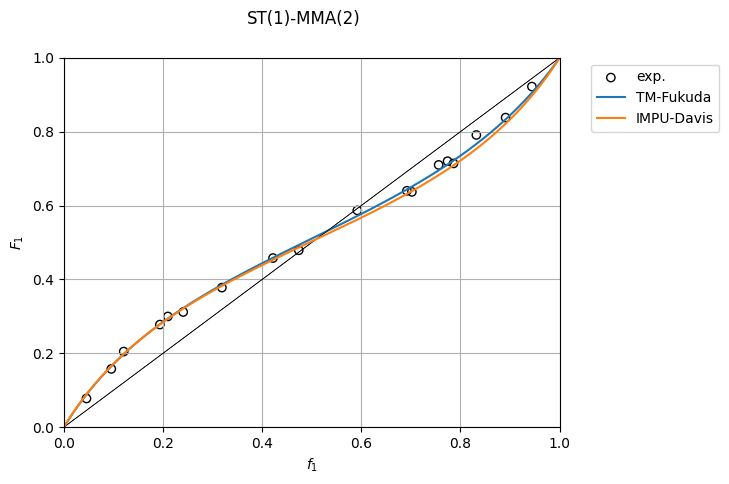

In [19]:
import matplotlib.pyplot as plt

# Data from https://doi.org/10.1021/ma00143a003
f1 = [0.046, 0.096, 0.121, 0.194, 0.21, 0.241, 0.319, 0.422, 0.474, 0.592,
      0.692, 0.702, 0.756, 0.774, 0.786, 0.832, 0.891, 0.944],
F1 = [0.078, 0.158, 0.205, 0.278, 0.3, 0.312, 0.378, 0.458, 0.479, 0.587,
      0.64, 0.637, 0.71, 0.72, 0.714, 0.791, 0.838, 0.922]

fig, ax = plt.subplots()
fig.suptitle("ST(1)-MMA(2)")
ax.scatter(f1, F1, facecolors='none', edgecolors='k', label="exp.")
tm.plot('Mayo', axes=ax)
pm.plot('Mayo', axes=ax)

The real difference between the two models concerns the average $k_p$...

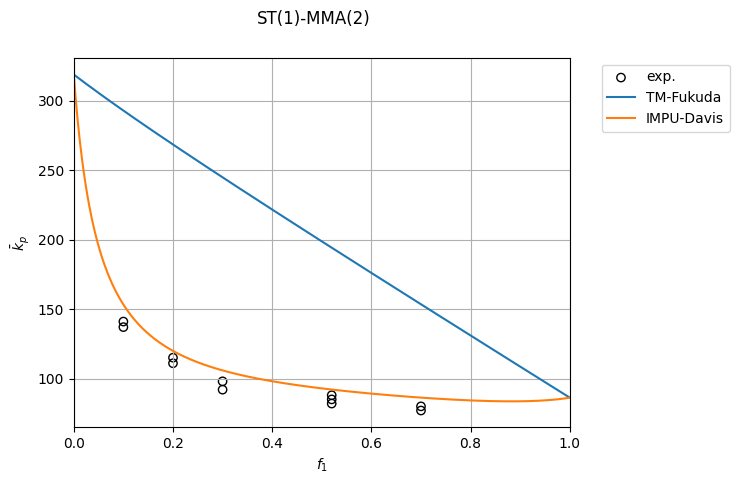

In [20]:
# Data from Davis et al. (1989)
f1 = [0.10, 0.10, 0.20, 0.20, 0.30, 0.30, 0.52, 0.52, 0.52, 0.70, 0.70]
kp = [141, 137, 115, 111, 98, 92, 88, 85, 82, 80, 77]

fig, ax = plt.subplots()
fig.suptitle("ST(1)-MMA(2)")
ax.scatter(f1, kp, facecolors='none', edgecolors='k', label="exp.")

T = 298.0 
tm.plot('kp', T=T, axes=ax)
pm.plot('kp', T=T, axes=ax)